# Implement the *Neilson hack* using `ws3` and `libcbm`

In this notebook we show how to implement the *Neilson hack* (i.e., generate carbon yield curves from a CBM for use in a forest estate model) using `ws3` and `libcbm`. 

In a nutshell, the *Neilson hack* consists of running a CBM from forest estate model output (see example notebook 030 and 031 for details), except that the inventory table gets hacked to have one record per development type (with age set to 0 and area set to 1) and no disturabance events are simulated. Carbon stock and flux data exported from the CBM can then be reformatted and imported in the forest estate model as carbon yield curves. That is about it. Should work for just about any `ws3` model. See Neilson et al. (2006) for details.

> Neilson, E. T., MacLean, D. A., Arp, P. A., Meng, F. R., Bourque, C. P., & Bhatti, J. S. (2006). Modeling carbon sequestration with CO2Fix and a timber supply model for use in forest management planning. Canadian journal of soil science, 86(Special Issue), 219-233.

In this notebook, we implement the Neilson hack from scratch. In notebook 041 we show how to use built-in `ws3` functions to automate this.

## Set up modelling environment

First, make sure we have the correct versions of `ws3` and `libcbm` installed. Both of these packages are relatively new and under active development, it is best we stick to known-working versions of each package from their respective GitHub repos. 


> We _strongly recommend_ that you run this notebook in venv-sandboxed Python kernel (see `venv_python_kernel_setup` notebook for an example of how to do this). This will ensure that you are working from a fresh Python package environment, and not wasting time debugging random interactions between this notebook and whatever mishmash of packages you have installed on your system in various parts of your Python path. You have been warned. 

In [1]:
%load_ext autoreload
%autoreload 2

In [15]:
install_ws3 = False
install_ws3_localeditable = False
if install_ws3:
    if install_ws3_localeditable: # clobber ws3 installation with local editable copy
        %pip uninstall -y ws3
        %pip install -e ..
    else: # install dev_libcbm branch from ws3 GitHub repo
        %pip install -U git+https://github.com/gparadis/ws3@dev_libcbm
    import ws3
    ws3.__path__

In [16]:
install_libcbm = False
if install_libcbm:
    %pip install -U git+https://github.com/cat-cfs/libcbm_py.git@main
    import libcbm
    libcbm.__path__

Create a `ForestModel` instance by loading Woodstock-formatted input files.

In [17]:
import ws3.forest

In [18]:
base_year = 2020
horizon = 10
period_length = 10
max_age = 1000
tvy_name = 'totvol'

In [99]:
fm = ws3.forest.ForestModel(model_name='tsa24_clipped',
                            model_path='data/woodstock_model_files',
                            base_year=base_year,
                            horizon=horizon,
                            period_length=period_length,
                            max_age=max_age)
fm.import_landscape_section()
fm.import_areas_section()
fm.import_yields_section()
fm.import_actions_section()
fm.import_transitions_section()
fm.initialize_areas()
fm.add_null_action()
fm.reset_actions()

In [100]:
fm.compile_schedule()

[]

Export standard SIT tables from `ws3` as a starting point.

In [101]:
disturbance_type_mapping = [{'user_dist_type': 'harvest', 'default_dist_type': 'Clearcut harvesting without salvage'},
                            {'user_dist_type': 'fire', 'default_dist_type': 'Wildfire'}]

In [102]:
for dtype_key in fm.dtypes:
    fm.dt(dtype_key).last_pass_disturbance = 'fire' if dtype_key[2] == dtype_key[4] else 'harvest'

In [103]:
sit_config, sit_tables = fm.to_cbm_sit(softwood_volume_yname='swdvol', 
                                       hardwood_volume_yname='hwdvol', 
                                       admin_boundary='British Columbia', 
                                       eco_boundary='Montane Cordillera',
                                       disturbance_type_mapping=disturbance_type_mapping)

The `sit_events` table should be empty, because we did not simulate any actions before calling `fm.to_cbm_sit`.

In [104]:
sit_tables['sit_events']

,theme0,theme1,theme2,theme3,theme4,species,using_age_class,min_softwood_age,max_softwood_age,min_hardwood_age,...,MinSWMerchStemSnagC,MaxSWMerchStemSnagC,MinHWMerchStemSnagC,MaxHWMerchStemSnagC,efficiency,sort_type,target_type,target,disturbance_type,disturbance_year


Rebuild the inventory table. We need one inventory record _for every possible development type_ (including system states that are not present in the initial inventory). Conveniently for us, `fm.to_cbm_sit` calls `fm._cbm_sit_yield`, which calls `fm.add_problem`, which calls `fm._bld_tree_m1`, which simulates all feasible combinations of actions, which creates any new development types that we need. You just have to know, and now you can leverage that side-effect to make this next part easy peasy. 

Figuring out which development types were missing and adding them by hand would not have been _too_ difficult for the simple test dataset we are are using here (assuming you are good at reading Woodstock input files and running through all possible future states in your head), but this could be a doozie of a puzzle or larger models with hundreds of initial development types and more complex actions and transitions. Basically, you definitely want to take note of the `add_problem` hack described about and use that. Any other way is just looking for trouble.

We can reuse the `sit_inventory` table returned from `fm.to_cbm_sit` to make sure we have the correct structure.

In [105]:
df = sit_tables['sit_inventory']
df = df.iloc[0:0]
df

,theme0,theme1,theme2,theme3,theme4,species,using_age_class,age,area,delay,landclass,historic_disturbance,last_pass_disturbance


In [106]:
import pandas as pd

In [107]:
data = []
for dtype_key in fm.dtypes:
    dt = fm.dt(dtype_key)
    values = list(dtype_key) 
    values += [dt.leading_species, 'FALSE', 0, 1., 0, 0, 'fire', 'fire' if dtype_key[2] == dtype_key[4] else 'harvest']
    data.append(dict(zip(df.columns, values)))
sit_tables['sit_inventory'] = pd.DataFrame(data)
sit_tables['sit_inventory']

,theme0,theme1,theme2,theme3,theme4,species,using_age_class,age,area,delay,landclass,historic_disturbance,last_pass_disturbance
0,tsa24_clipped,0,2401000,100,2401000,softwood,FALSE,0,1.0,0,0,fire,fire
1,tsa24_clipped,0,2402005,1201,2402005,hardwood,FALSE,0,1.0,0,0,fire,fire
2,tsa24_clipped,1,2401002,204,2401002,softwood,FALSE,0,1.0,0,0,fire,fire
3,tsa24_clipped,1,2401002,204,2421002,softwood,FALSE,0,1.0,0,0,fire,harvest
4,tsa24_clipped,1,2402000,100,2402000,softwood,FALSE,0,1.0,0,0,fire,fire
5,tsa24_clipped,1,2402002,204,2402002,softwood,FALSE,0,1.0,0,0,fire,fire
6,tsa24_clipped,1,2403000,100,2403000,softwood,FALSE,0,1.0,0,0,fire,fire
7,tsa24_clipped,1,2403002,204,2403002,softwood,FALSE,0,1.0,0,0,fire,fire
8,tsa24_clipped,1,2403002,204,2423002,softwood,FALSE,0,1.0,0,0,fire,harvest
9,tsa24_clipped,1,2402000,100,2422000,softwood,FALSE,0,1.0,0,0,fire,harvest


Now we run this thruogh `libcbm` for 300 time steps.

In [108]:
disturbance_type_mapping = [{'user_dist_type': 'harvest', 'default_dist_type': 'Clearcut harvesting without salvage'},
                            {'user_dist_type': 'fire', 'default_dist_type': 'Wildfire'}]

In [109]:
for dtype_key in fm.dtypes:
    fm.dt(dtype_key).last_pass_disturbance = 'fire' if dtype_key[2] == dtype_key[4] else 'harvest'

In [110]:
from util import run_cbm

In [111]:
n_steps = 300
cbm_output = run_cbm(sit_config, sit_tables, n_steps, plot=False)

/media/data/home/gparadis/.virtualenvs/foo/lib/python3.10/site-packages/libcbm/resources/__init__.py:113: RuntimeWarning: unsupported linux distribution: Linux-5.15.0-46-generic-x86_64-with-glibc2.35
  warnings.warn(message, RuntimeWarning)


In [112]:
cbm_output

In [169]:
pi = cbm_output.classifiers.to_pandas().merge(cbm_output.pools.to_pandas(), 
                                              left_on=["identifier", "timestep"], 
                                              right_on=["identifier", "timestep"])
fi = cbm_output.classifiers.to_pandas().merge(cbm_output.flux.to_pandas(), 
                                              left_on=["identifier", "timestep"], 
                                              right_on=["identifier", "timestep"])

In [170]:
pi

,identifier,timestep,theme0,theme1,theme2,theme3,theme4,species,Input,SoftwoodMerch,...,BelowGroundSlowSoil,SoftwoodStemSnag,SoftwoodBranchSnag,HardwoodStemSnag,HardwoodBranchSnag,CO2,CH4,CO,NO2,Products
0,1,0,tsa24_clipped,0,2401000,100,2401000,softwood,1.0,0.000000,...,61.072161,28.616202,19.461734,0.000000,0.000000,4790.526504,4.942348,44.479699,0.0,0.000000
1,2,0,tsa24_clipped,0,2402005,1201,2402005,hardwood,1.0,0.000000,...,114.491754,0.000000,0.000000,65.448939,18.985542,9638.462743,8.550696,76.954017,0.0,0.000000
2,3,0,tsa24_clipped,1,2401002,204,2401002,softwood,1.0,0.000000,...,70.577311,38.209170,20.940326,0.000000,0.000000,5549.131806,5.574412,50.168153,0.0,0.000000
3,4,0,tsa24_clipped,1,2401002,204,2421002,softwood,1.0,0.000000,...,56.591833,0.000000,0.000000,0.000000,0.000000,4504.469208,4.878363,43.903950,0.0,34.110922
4,5,0,tsa24_clipped,1,2402000,100,2402000,softwood,1.0,0.000000,...,78.415619,47.913734,22.404296,0.000000,0.000000,6182.050833,6.060943,54.546827,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3607,8,300,tsa24_clipped,1,2403002,204,2403002,softwood,1.0,63.042997,...,110.566427,10.465389,1.954894,0.000000,0.000000,9088.654777,7.694727,69.250637,0.0,0.000000
3608,9,300,tsa24_clipped,1,2403002,204,2423002,softwood,1.0,92.723531,...,118.471450,9.851096,2.270104,0.000000,0.000000,9070.482693,7.597707,68.377586,0.0,79.633546
3609,10,300,tsa24_clipped,1,2402000,100,2422000,softwood,1.0,74.795270,...,87.528498,7.785973,2.065819,0.000000,0.000000,6201.980905,5.599995,50.398516,0.0,48.597173
3610,11,300,tsa24_clipped,1,2402002,204,2422002,softwood,1.0,66.253514,...,93.752506,6.990460,1.970435,0.000000,0.000000,6923.626178,6.063782,54.572506,0.0,53.757580


In [175]:
pi.columns

Index(['identifier', 'timestep', 'theme0', 'theme1', 'theme2', 'theme3',
       'theme4', 'species', 'Input', 'SoftwoodMerch', 'SoftwoodFoliage',
       'SoftwoodOther', 'SoftwoodCoarseRoots', 'SoftwoodFineRoots',
       'HardwoodMerch', 'HardwoodFoliage', 'HardwoodOther',
       'HardwoodCoarseRoots', 'HardwoodFineRoots', 'AboveGroundVeryFastSoil',
       'BelowGroundVeryFastSoil', 'AboveGroundFastSoil', 'BelowGroundFastSoil',
       'MediumSoil', 'AboveGroundSlowSoil', 'BelowGroundSlowSoil',
       'SoftwoodStemSnag', 'SoftwoodBranchSnag', 'HardwoodStemSnag',
       'HardwoodBranchSnag', 'CO2', 'CH4', 'CO', 'NO2', 'Products',
       'dtype_key'],
      dtype='object')

In [171]:
fi

,identifier,timestep,theme0,theme1,theme2,theme3,theme4,species,DisturbanceCO2Production,DisturbanceCH4Production,...,DisturbanceVFastBGToAir,DisturbanceFastAGToAir,DisturbanceFastBGToAir,DisturbanceMediumToAir,DisturbanceSlowAGToAir,DisturbanceSlowBGToAir,DisturbanceSWStemSnagToAir,DisturbanceSWBranchSnagToAir,DisturbanceHWStemSnagToAir,DisturbanceHWBranchSnagToAir
0,1,0,tsa24_clipped,0,2401000,100,2401000,softwood,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0,tsa24_clipped,0,2402005,1201,2402005,hardwood,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0,tsa24_clipped,1,2401002,204,2401002,softwood,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0,tsa24_clipped,1,2401002,204,2421002,softwood,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0,tsa24_clipped,1,2402000,100,2402000,softwood,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3607,8,300,tsa24_clipped,1,2403002,204,2403002,softwood,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3608,9,300,tsa24_clipped,1,2403002,204,2423002,softwood,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3609,10,300,tsa24_clipped,1,2402000,100,2422000,softwood,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3610,11,300,tsa24_clipped,1,2402002,204,2422002,softwood,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [174]:
fi.columns

Index(['identifier', 'timestep', 'theme0', 'theme1', 'theme2', 'theme3',
       'theme4', 'species', 'DisturbanceCO2Production',
       'DisturbanceCH4Production', 'DisturbanceCOProduction',
       'DisturbanceBioCO2Emission', 'DisturbanceBioCH4Emission',
       'DisturbanceBioCOEmission', 'DecayDOMCO2Emission',
       'DisturbanceSoftProduction', 'DisturbanceHardProduction',
       'DisturbanceDOMProduction', 'DeltaBiomass_AG', 'DeltaBiomass_BG',
       'TurnoverMerchLitterInput', 'TurnoverFolLitterInput',
       'TurnoverOthLitterInput', 'TurnoverCoarseLitterInput',
       'TurnoverFineLitterInput', 'DecayVFastAGToAir', 'DecayVFastBGToAir',
       'DecayFastAGToAir', 'DecayFastBGToAir', 'DecayMediumToAir',
       'DecaySlowAGToAir', 'DecaySlowBGToAir', 'DecaySWStemSnagToAir',
       'DecaySWBranchSnagToAir', 'DecayHWStemSnagToAir',
       'DecayHWBranchSnagToAir', 'DisturbanceMerchToAir',
       'DisturbanceFolToAir', 'DisturbanceOthToAir', 'DisturbanceCoarseToAir',
       'Disturban

Now we just need to recompile this data into yield curves and stuff them back into our `ForestModel` instance.

In [176]:
biomass_pools = ['SoftwoodMerch','SoftwoodFoliage', 'SoftwoodOther', 'SoftwoodCoarseRoots','SoftwoodFineRoots',                        
                 'HardwoodMerch', 'HardwoodFoliage', 'HardwoodOther', 'HardwoodCoarseRoots', 'HardwoodFineRoots']
dom_pools = ['AboveGroundVeryFastSoil', 'BelowGroundVeryFastSoil', 'AboveGroundFastSoil', 'BelowGroundFastSoil',
             'MediumSoil', 'AboveGroundSlowSoil', 'BelowGroundSlowSoil', 'SoftwoodStemSnag', 'SoftwoodBranchSnag',
             'HardwoodStemSnag', 'HardwoodBranchSnag']
other_pools = ['CO2', 'CH4', 'CO', 'NO2', 'Products']
all_pools = biomass_pools + dom_pools + other_pools

In [180]:
all_fluxes = ['DisturbanceCO2Production',
              'DisturbanceCH4Production', 'DisturbanceCOProduction',
              'DisturbanceBioCO2Emission', 'DisturbanceBioCH4Emission',
              'DisturbanceBioCOEmission', 'DecayDOMCO2Emission',
              'DisturbanceSoftProduction', 'DisturbanceHardProduction',
              'DisturbanceDOMProduction', 'DeltaBiomass_AG', 'DeltaBiomass_BG',
              'TurnoverMerchLitterInput', 'TurnoverFolLitterInput',
              'TurnoverOthLitterInput', 'TurnoverCoarseLitterInput',
              'TurnoverFineLitterInput', 'DecayVFastAGToAir', 'DecayVFastBGToAir',
              'DecayFastAGToAir', 'DecayFastBGToAir', 'DecayMediumToAir',
              'DecaySlowAGToAir', 'DecaySlowBGToAir', 'DecaySWStemSnagToAir',
              'DecaySWBranchSnagToAir', 'DecayHWStemSnagToAir',
              'DecayHWBranchSnagToAir', 'DisturbanceMerchToAir',
              'DisturbanceFolToAir', 'DisturbanceOthToAir', 'DisturbanceCoarseToAir',
              'DisturbanceFineToAir', 'DisturbanceDOMCO2Emission',
              'DisturbanceDOMCH4Emission', 'DisturbanceDOMCOEmission',
              'DisturbanceMerchLitterInput', 'DisturbanceFolLitterInput',
              'DisturbanceOthLitterInput', 'DisturbanceCoarseLitterInput',
              'DisturbanceFineLitterInput', 'DisturbanceVFastAGToAir',
              'DisturbanceVFastBGToAir', 'DisturbanceFastAGToAir',
              'DisturbanceFastBGToAir', 'DisturbanceMediumToAir',
              'DisturbanceSlowAGToAir', 'DisturbanceSlowBGToAir',
              'DisturbanceSWStemSnagToAir', 'DisturbanceSWBranchSnagToAir',
              'DisturbanceHWStemSnagToAir', 'DisturbanceHWBranchSnagToAir']

In [179]:
pi['dtype_key'] = pi.apply(lambda r: '%s %s %s %s %s' % (r['theme0'], r['theme1'], r['theme2'], r['theme3'], r['theme4']), axis=1)
fi['dtype_key'] = fi.apply(lambda r: '%s %s %s %s %s' % (r['theme0'], r['theme1'], r['theme2'], r['theme3'], r['theme4']), axis=1)

In [181]:
pi_gb_sum = pi.groupby(['dtype_key', 'timestep'], as_index=True)[all_pools].sum()
fi_gb_sum = fi.groupby(['dtype_key', 'timestep'], as_index=True)[all_fluxes].sum()

Reformatted this way, we essentially have carbon yield curves now.

In [182]:
pi_gb_sum

SoftwoodMerch  SoftwoodFoliage  \
dtype_key                           timestep                                   
tsa24_clipped 0 2401000 100 2401000 0              0.000000         0.000000   
                                    1              0.000036         0.132721   
                                    2              0.000305         0.370208   
                                    3              0.001061         0.611266   
                                    4              0.002569         0.774699   
...                                                     ...              ...   
tsa24_clipped 1 2403002 204 2423002 296           92.723531         8.635211   
                                    297           92.723531         8.635211   
                                    298           92.723531         8.635211   
                                    299           92.723531         8.635211   
                                    300           92.723531         8.635211   

                                              SoftwoodOther  \
dtype_key                           timestep                  
tsa24_clipped 0 2401000 100 2401000 0              0.000000   
                                    1              0.000000   
                                    2              0.000000   
                                    3              0.061592   
                                    4              0.251065   
...                                                     ...   
tsa24_clipped 1 2403002 204 2423002 296           32.241928   
                                    297           32.241928   
                                    298           32.241928   
                                    299           32.241928   
                                    300           32.241928   

                                              SoftwoodCoarseRoots  \
dtype_key                           timestep                        
tsa24_clipped 0 2401000 100 2401000 0                    0.000000   
                                    1                    0.016954   
                                    2                    0.047501   
                                    3                    0.086822   
                                    4                    0.133230   
...                                                           ...   
tsa24_clipped 1 2403002 204 2423002 296                 27.228756   
                                    297                 27.228756   
                                    298                 27.228756   
                                    299                 27.228756   
                                    300                 27.228756   

                                              SoftwoodFineRoots  \
dtype_key                           timestep                      
tsa24_clipped 0 2401000 100 2401000 0                  0.000000   
                                    1                  0.012518   
                                    2                  0.034753   
                                    3                  0.062788   
                                    4                  0.095060   
...                                                         ...   
tsa24_clipped 1 2403002 204 2423002 296                2.430592   
                                    297                2.430592   
                                    298                2.430592   
                                    299                2.430592   
                                    300                2.430592   

                                              HardwoodMerch  HardwoodFoliage  \
dtype_key                           timestep                                   
tsa24_clipped 0 2401000 100 2401000 0                   0.0              0.0   
                                    1                   0.0              0.0   
                                    2                   0.0              0.0   
               

In [183]:
fi_gb_sum

DisturbanceCO2Production  \
dtype_key                           timestep                             
tsa24_clipped 0 2401000 100 2401000 0                              0.0   
                                    1                              0.0   
                                    2                              0.0   
                                    3                              0.0   
                                    4                              0.0   
...                                                                ...   
tsa24_clipped 1 2403002 204 2423002 296                            0.0   
                                    297                            0.0   
                                    298                            0.0   
                                    299                            0.0   
                                    300                            0.0   

                                              DisturbanceCH4Production  \
dtype_key                           timestep                             
tsa24_clipped 0 2401000 100 2401000 0                              0.0   
                                    1                              0.0   
                                    2                              0.0   
                                    3                              0.0   
                                    4                              0.0   
...                                                                ...   
tsa24_clipped 1 2403002 204 2423002 296                            0.0   
                                    297                            0.0   
                                    298                            0.0   
                                    299                            0.0   
                                    300                            0.0   

                                              DisturbanceCOProduction  \
dtype_key                           timestep                            
tsa24_clipped 0 2401000 100 2401000 0                             0.0   
                                    1                             0.0   
                                    2                             0.0   
                                    3                             0.0   
                                    4                             0.0   
...                                                               ...   
tsa24_clipped 1 2403002 204 2423002 296                           0.0   
                                    297                           0.0   
                                    298                           0.0   
                                    299                           0.0   
                                    300                           0.0   

                                              DisturbanceBioCO2Emission  \
dtype_key                           timestep                              
tsa24_clipped 0 2401000 100 2401000 0                               0.0   
                                    1                               0.0   
                                    2                               0.0   
                                    3                               0.0   
                                    4                               0.0   
...                                                                 ...   
tsa24_clipped 1 2403002 204 2423002 296                             0.0   
                                    297                             0.0   
                                    298                             0.0   
                                    299                             0.0   
                                    300                             0.0   

                                              DisturbanceBioCH4Emission  \
dtype_key                           timestep                              
tsa24_clipped 0 2401000 100 2401000 0       

Add carbon yield curves to our model.

In [184]:
for dtype_key in fm.dtypes:
    dt = fm.dt(dtype_key)
    mask = ('?', '?', dtype_key[2], '?', dtype_key[4])
    for _mask, ytype, curves in fm.yields:
        if _mask != mask: continue # we know there will be a match so this works
        print('found match for mask', mask)
        pool_data = pi_gb_sum.loc[' '.join(dtype_key)]
        for yname in all_pools:
            points = list(zip(pool_data.index.values, pool_data[yname]))
            curve = fm.register_curve(ws3.core.Curve(yname, 
                                                     points=points, 
                                                     type='a', 
                                                     is_volume=False,
                                                     xmax=fm.max_age,
                                                     period_length=fm.period_length))
            curves.append((yname, curve))
            dt.add_ycomp('a', yname, curve)
        flux_data = fi_gb_sum.loc[' '.join(dtype_key)]
        for yname in all_fluxes:
            points = list(zip(flux_data.index.values, flux_data[yname]))
            curve = fm.register_curve(ws3.core.Curve(yname, 
                                                     points=points, 
                                                     type='a', 
                                                     is_volume=False,
                                                     xmax=fm.max_age,
                                                     period_length=fm.period_length))
            curves.append((yname, curve))
            dt.add_ycomp('a', yname, curve)
    #mask = '? ? %s ? %' % (dtype_key[2], dtype_key[4])
    #points = pi_gb_sum

found match for mask ('?', '?', '2401000', '?', '2401000')
found match for mask ('?', '?', '2401000', '?', '2401000')
found match for mask ('?', '?', '2402005', '?', '2402005')
found match for mask ('?', '?', '2402005', '?', '2402005')
found match for mask ('?', '?', '2401002', '?', '2401002')
found match for mask ('?', '?', '2401002', '?', '2421002')
found match for mask ('?', '?', '2402000', '?', '2402000')
found match for mask ('?', '?', '2402002', '?', '2402002')
found match for mask ('?', '?', '2403000', '?', '2403000')
found match for mask ('?', '?', '2403002', '?', '2403002')
found match for mask ('?', '?', '2403002', '?', '2423002')
found match for mask ('?', '?', '2402000', '?', '2422000')
found match for mask ('?', '?', '2402002', '?', '2422002')
found match for mask ('?', '?', '2403000', '?', '2423000')


In [185]:
fm.reset()

In [186]:
fm.grow()

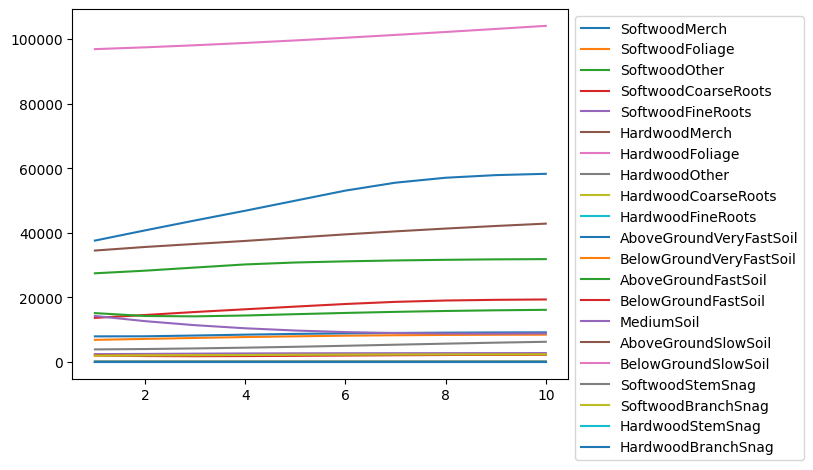

In [189]:
import matplotlib.pyplot as plt
for pool in all_pools[:-5]: # skip the gas pools for now
    x, y = fm.periods, [fm.inventory(p, pool) for p in fm.periods]
    plt.plot(x, y, label=pool)
plt.legend(bbox_to_anchor=(1, 1))

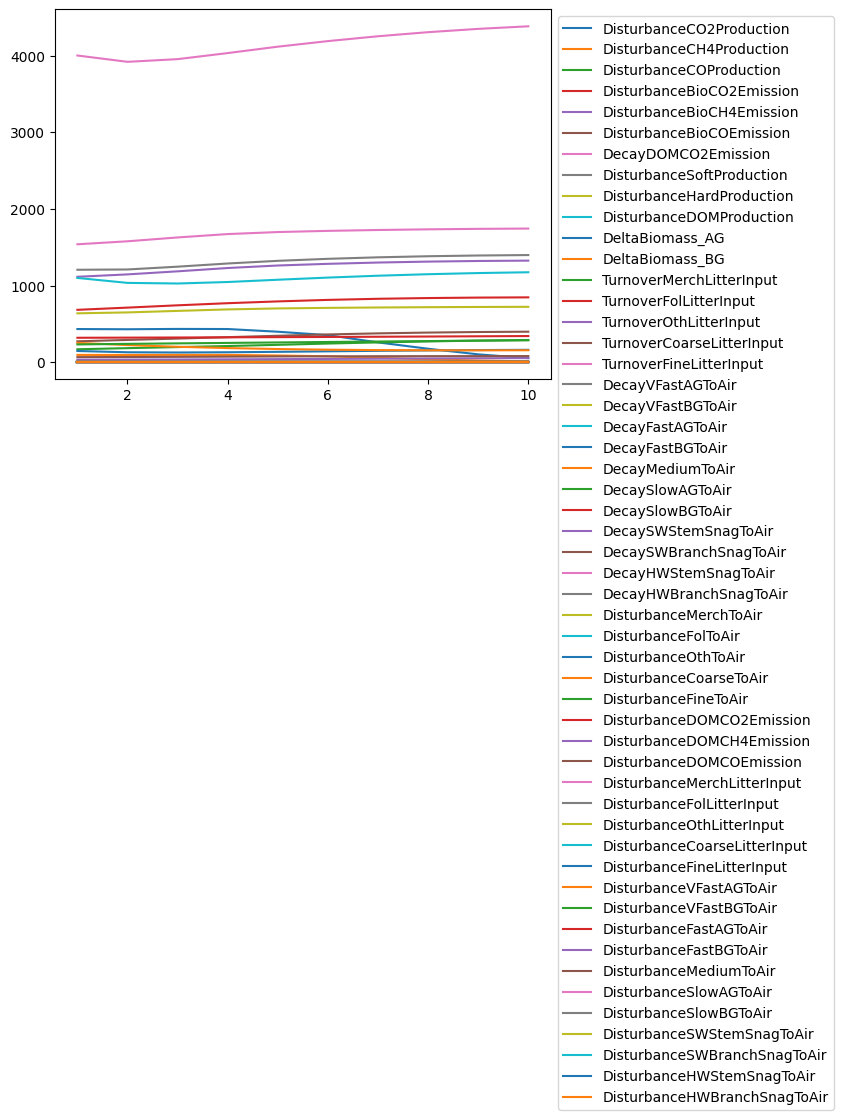

In [190]:
import matplotlib.pyplot as plt
for flux in all_fluxes[:]:
    x, y = fm.periods, [fm.inventory(p, flux) for p in fm.periods]
    plt.plot(x, y, label=flux)
plt.legend(bbox_to_anchor=(1, 1))

Not the most pretty or informative plots, but the point is that we are new tracking 26 new carbon pools and 52 new carbon fluxes in our model. 

Bam!

To make this more useful in a production model, we would likely also want to define some complex yields that aggregate groups of pools and fluxes, and then use these aggregate indicators either as part of the objective function or constraints of an optimization model (i.e., to include carbon in management strategy) or simply as an output indicator (i.e., for reporting on scenario performance without directly influencing the management strategy). 